# Libraries

In [1]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [3]:
import os
from tqdm.auto import tqdm 
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count
import polars as pl
from sklearn.preprocessing import MinMaxScaler
import concurrent.futures

from datetime import datetime, timezone, timedelta

# Current leaderboard

In [4]:
leaderboard = pd.read_csv('/kaggle/input/leaderboard27112024/LEADERBOARD.csv')
leaderboard

,Rank,TeamId,TeamName,LastSubmissionDate,Score,SubmissionCount,TeamMemberUserNames
0,1,12638980,💤💤💤yukiZ💤💤💤,2024-11-27 10:22:36,0.499,313,hideyukizushi
1,2,12754661,GiveMeHope,2024-11-27 07:12:13,0.497,214,xdunlper
2,3,12710207,Syed Usman Ahmad,2024-11-27 14:42:11,0.497,263,syedusmanahmad
3,4,12633850,Gritty,2024-11-26 23:25:42,0.497,244,paulnkamau
4,5,12670709,Rabia Mushtaq,2024-11-27 13:38:32,0.497,96,rabiya335
...,...,...,...,...,...,...,...
2603,2603,12716620,Durgesh,2024-10-07 08:37:35,-0.019,2,orionpax00
2604,2604,12797354,Jimii fcv,2024-11-25 12:49:27,-0.023,7,jimiifcv
2605,2605,12673312,masatoito8823,2024-09-28 04:36:38,-0.041,1,masatoito8823
2606,2606,12849443,zhuochen416,2024-11-15 13:02:07,-0.080,3,zhuochen416


Percentage of teams with Score > 0.45: 66.18%
Percentage of teams with Score <= 0.45: 33.82%


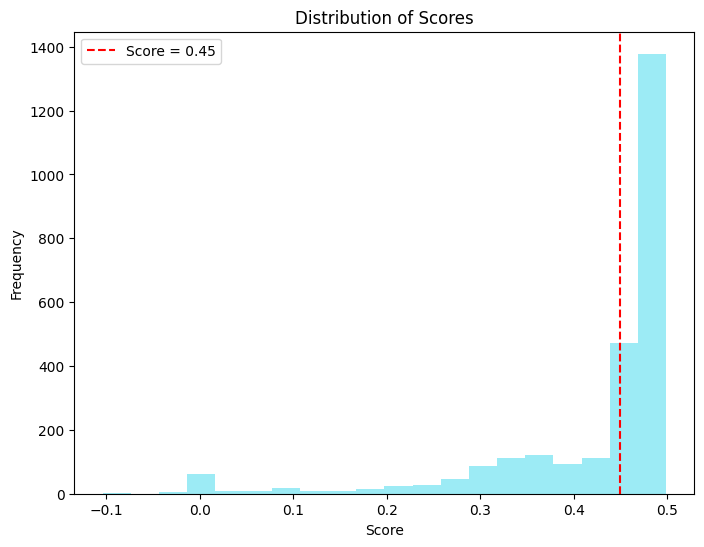

In [5]:
# Create the histogram with 20 bins, purple bars, and no lines around the bars
plt.figure(figsize=(8, 6))
plt.hist(leaderboard['Score'], bins=20, color='#72E3F2', edgecolor='none', alpha=0.7)

# Add a red vertical line at score 0.45
plt.axvline(x=0.45, color='red', linestyle='--', label='Score = 0.45')

# Calculate the percentage of teams with score higher than 0.45 and lower than or equal to 0.45
higher_than_0_45 = (leaderboard['Score'] > 0.45).sum()
lower_or_equal_to_0_45 = (leaderboard['Score'] <= 0.45).sum()

total_teams = len(leaderboard)
percentage_higher = (higher_than_0_45 / total_teams) * 100
percentage_lower_or_equal = (lower_or_equal_to_0_45 / total_teams) * 100

# Display the percentages
print(f"Percentage of teams with Score > 0.45: {percentage_higher:.2f}%")
print(f"Percentage of teams with Score <= 0.45: {percentage_lower_or_equal:.2f}%")

# Adding labels and title
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

# Load the data

In [6]:
df_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
len(df_test)

20

In [7]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [8]:
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
len(test_ts)

  0%|          | 0/2 [00:00<?, ?it/s]

2

In [9]:
test_ts['id'].unique()

array(['00115b9f', '001f3379'], dtype=object)

In [10]:
df = pd.read_csv('/kaggle/input/colombian-frenchteam-problematicinternetusage/Dataset_problematic_internet_usage.csv')
len(df)

3960

In [11]:
df.groupby('Train_Test_Label').size()

Train_Test_Label
isnotintrainset    2964
test                200
train               796
dtype: int64

In [12]:
df = df[(df['Train_Test_Label']=='test') | (df['Train_Test_Label']=='train') ]
len(df)

996

In [13]:
df[df['sii']==3].head(3)

,Unnamed: 0,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Has_actigraphy_data,Train_Test_Label
894,894,35fa2ebf,Summer,13,0,Fall,70.0,Fall,20.404192,61.00,...,5.0,89.0,Fall,37.0,53.0,Summer,3.0,3.0,Yes,train
1502,1502,5e55e9fd,Spring,14,1,NaN,NaN,Spring,18.934295,60.75,...,5.0,81.0,Spring,44.0,62.0,Spring,3.0,3.0,Yes,train
2002,2002,7f44236f,Fall,13,0,Winter,70.0,Winter,25.370016,67.00,...,5.0,87.0,Winter,47.0,66.0,Fall,0.0,3.0,Yes,train


In [14]:
df[df['sii']==0].head(3)

,Unnamed: 0,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Has_actigraphy_data,Train_Test_Label
22,22,01085eb3,Fall,12,0,Winter,58.0,Fall,34.187282,60.5,...,0.0,30.0,Fall,53.0,73.0,Fall,0.0,0.0,Yes,train
25,25,012cadd8,Spring,9,0,Winter,60.0,Fall,17.089151,53.2,...,0.0,9.0,Summer,27.0,40.0,Spring,0.0,0.0,Yes,train
26,26,012e3869,Summer,6,0,Winter,60.0,Summer,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,Summer,0.0,0.0,Yes,train


# Plot functions 2

In [15]:
kid_id = '71ee31f8'

In [16]:
def feat_eng(df):

    df['time_of_day_hours'] = (df['time_of_day'] / 1e9 / 3600)  # nanoseconds to hours
    df['time_of_day_half_hours'] = (df['time_of_day'] / 1e9 / 1800)  # nanoseconds to half-hours
    df['time_of_day_half_half_hours'] = (df['time_of_day'] / 1e9 / 900)  # nanoseconds to 15 minutes interval
    df['time_of_day_fivemin_hours'] = (df['time_of_day'] / 1e9 / 300)  # nanoseconds to 5 minutes interval
    df['day_time'] = df['relative_date_PCIAT'] + (df['time_of_day_hours'] / 24)
    
    # Day period assignment
    day_start_hour = 8
    day_end_hour = 21
    df['day_period'] = np.where(
            (df['time_of_day_hours'] >= day_start_hour) &
            (df['time_of_day_hours'] < day_end_hour),
            'day', 'night'
        )
    
    # Initialize the 'which_day' column and day change detection
    df['which_day'] = 0
    day_change = (
            (df['weekday'] != df['weekday'].shift(1)) |
            (df['hour'] < df['hour'].shift(1)) |
            ((df['hour'] == df['hour'].shift(1)) & (df['minute'] < df['minute'].shift(1))) |
            ((df['hour'] == df['hour'].shift(1)) & (df['minute'] == df['minute'].shift(1)) & (df['second'] < df['second'].shift(1)))
        )
    df['which_day'] = day_change.cumsum() + 1
    df['day_period_b'] = np.where(df['day_period'] == 'day', 1, 0)
    df['time_of_day'] = pd.to_timedelta(df['time_of_day'], unit='ns')
    base_date = pd.to_datetime('2024-01-01')
    df['date'] = base_date + pd.to_timedelta(df['which_day'] - 1, unit='D')
    df['timestamp'] = df['date'] + df['time_of_day']
    df['timestamp'] = df['timestamp'].apply(lambda t: t.tz_localize(None))
    df['timestamp_2'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df.sort_values(['timestamp_2'], inplace=True)
    df.set_index('timestamp_2', inplace=True)
    
    df["anglez"] = df["anglez"].astype(np.float32)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float32)
        
    for col in ['anglezdiffabs']:
            
        # periods in seconds        
        periods = [60] 
            
        for n in periods:
                
            rol_args = {'window':f'{n+5}s', 'min_periods':10, 'center':True}
                
            for agg in ['median']:
                df[f'{col}_{agg}_{n}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()
                
            gc.collect()
    
    df.reset_index(inplace=True)
    df.dropna(inplace=True)
    df['large_enmo'] = df['enmo'] > 0.1509000062942505
    df['anglezdiffabs_median_60_norm'] = (df['anglezdiffabs_median_60'] - np.min(df['anglezdiffabs_median_60'])) / (max(df['anglezdiffabs_median_60']) - min(df['anglezdiffabs_median_60']))

    return df

In [17]:
def feat_eng_by_id(idx):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df = (
        pl.scan_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={idx}/part-0.parquet')
        .with_columns(
            (pl.col("time_of_day").cast(pl.Int64) / 1_000_000_000).alias("total_seconds")
        )
        .with_columns(
            [
                (pl.col("total_seconds") // 3600).alias("hour"),
                ((pl.col("total_seconds") % 3600) // 60).alias("minute"),
                (pl.col("total_seconds") % 60).alias("second"),
            ]
        )
        .collect()
        .to_pandas()
    )

    df = feat_eng(df)
    
    return df



In [18]:
from tqdm.auto import tqdm 
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count
import gc

In [19]:
from pathlib import Path
working_folder = Path("/kaggle/working/")
images_folder = working_folder/"imagesandannotations"
images_folder.mkdir()

window_properties_batch_file = os.path.join(images_folder, "window_properties.json")
all_events_batch_file = os.path.join(images_folder, "all_events.json")

In [20]:
series_ids = df['id'].unique()
len(series_ids)

996

In [21]:
series_ids = series_ids[950:]
#series_ids = series_ids[0:2]
series_ids

array(['f64ae747', 'f67908e7', 'f6b719ee', 'f6c0e2b7', 'f6c20447',
       'f6cc80a9', 'f6d6f400', 'f6d879aa', 'f74eda33', 'f75c957f',
       'f7b1374e', 'f7fc97cf', 'f81598bf', 'f8674e15', 'f869d220',
       'f8bf4a1c', 'f8ff0bc8', 'f93010a8', 'f9334e08', 'f9384fa2',
       'fa34f945', 'fa3e1e21', 'fa633e39', 'fa9a0add', 'fab75c2c',
       'fad07fce', 'fb04f7dd', 'fb3c2c87', 'fb9c5a33', 'fc2c2c08',
       'fc41be2f', 'fc49ba65', 'fc8e4de4', 'fd028ecc', 'fd0d9bca',
       'fd56e059', 'fdb6b48b', 'fdc11b96', 'fdea7d9e', 'fdf4691f',
       'fe3cbf02', 'fe9c71d8', 'fecc07d6', 'ff18b749', 'ffcd4dbd',
       'ffed1dd5'], dtype=object)

In [31]:
filtered_data = feat_eng_by_id('7f44236f') #feat_eng_by_id('f64ae747')

In [32]:
filtered_data.head(5)

,timestamp_2,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,...,day_time,day_period,which_day,day_period_b,date,timestamp,anglezdiffabs,anglezdiffabs_median_60,large_enmo,anglezdiffabs_median_60_norm
4,2024-01-02 11:53:20,4,-0.063011,-0.057969,-0.996158,0.017807,-85.098434,0.0,15.333333,4183.666504,...,1.495370,day,2,1,2024-01-02,2024-01-02 11:53:20,0.163002,0.106514,False,0.002499
5,2024-01-02 11:53:25,5,-0.062920,-0.058662,-0.995661,0.012207,-85.093994,0.0,16.000000,4183.333496,...,1.495428,day,2,1,2024-01-02,2024-01-02 11:53:25,0.004440,0.152481,False,0.003578
6,2024-01-02 11:53:30,6,-0.061883,-0.083677,-0.994185,0.009930,-83.982208,0.0,10.250000,4183.000000,...,1.495486,day,2,1,2024-01-02,2024-01-02 11:53:30,1.111786,0.156311,False,0.003668
7,2024-01-02 11:53:35,7,-0.068742,-0.088926,-0.996066,0.002996,-83.621124,0.0,6.666667,4182.666504,...,1.495544,day,2,1,2024-01-02,2024-01-02 11:53:35,0.361084,0.160141,False,0.003758
8,2024-01-02 11:53:40,8,-0.068613,-0.088849,-0.995439,0.002514,-83.601990,0.0,13.000000,4182.333496,...,1.495602,day,2,1,2024-01-02,2024-01-02 11:53:40,0.019135,0.160141,False,0.003758


In [37]:
filtered_data.groupby('which_day')['non-wear_flag'].mean()

which_day
2     0.000000
3     0.343750
4     0.312500
5     0.203096
6     0.812500
7     0.833333
8     0.927083
9     0.395833
10    0.447917
11    0.520833
12    0.296904
13    0.651013
14    0.864583
15    0.427083
16    0.234404
17    0.609346
18    0.359404
19    0.093750
20    0.848929
21    0.770833
22    0.354167
23    0.479167
24    0.385417
25    0.439394
Name: non-wear_flag, dtype: float32

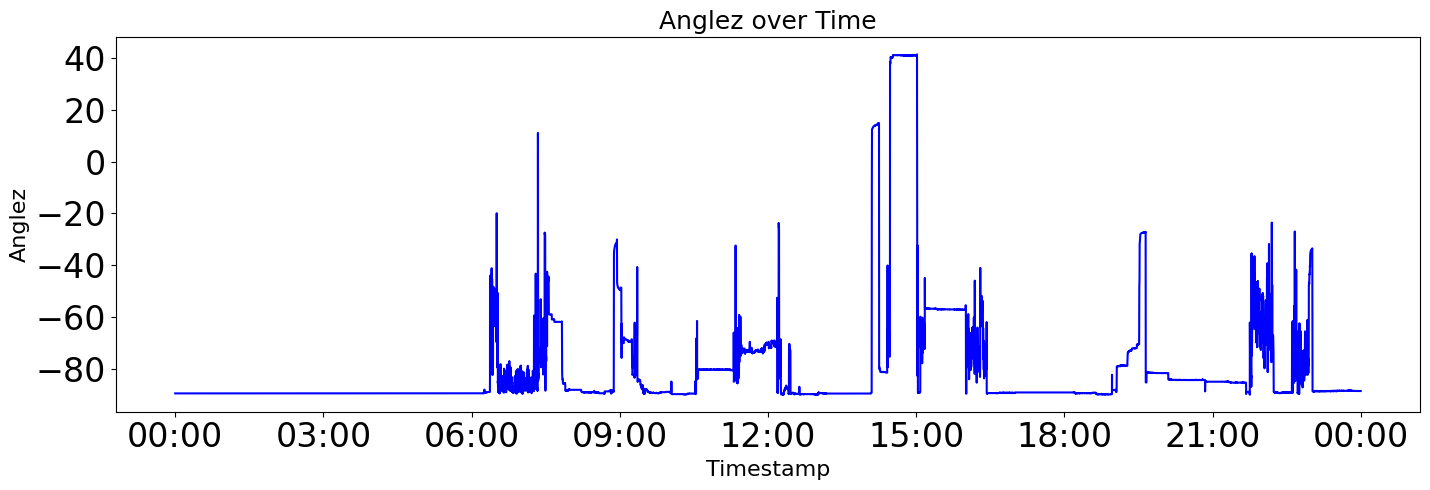

In [44]:
filtered_data_ = filtered_data[filtered_data['which_day']==12]

import matplotlib.dates as mdates

plt.figure(figsize=(14.4, 5))  # Adjust the figure size if needed
plt.plot(filtered_data_['timestamp'], filtered_data_['anglez'], linestyle='-', color='b')

# Adding labels and title with increased font size
plt.xlabel('Timestamp', fontsize=16)  # Increased font size for x-axis label
plt.ylabel('Anglez', fontsize=16)     # Increased font size for y-axis label
plt.title('Anglez over Time', fontsize=18)  # Increased font size for title

# Formatting the x-axis to display HH:MM format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0, fontsize=24)  # Increased font size for x-axis tick labels
plt.yticks(fontsize=24)              # Increased font size for y-axis tick labels

# Show the plot
plt.tight_layout()  # To ensure the layout is nice
plt.show()

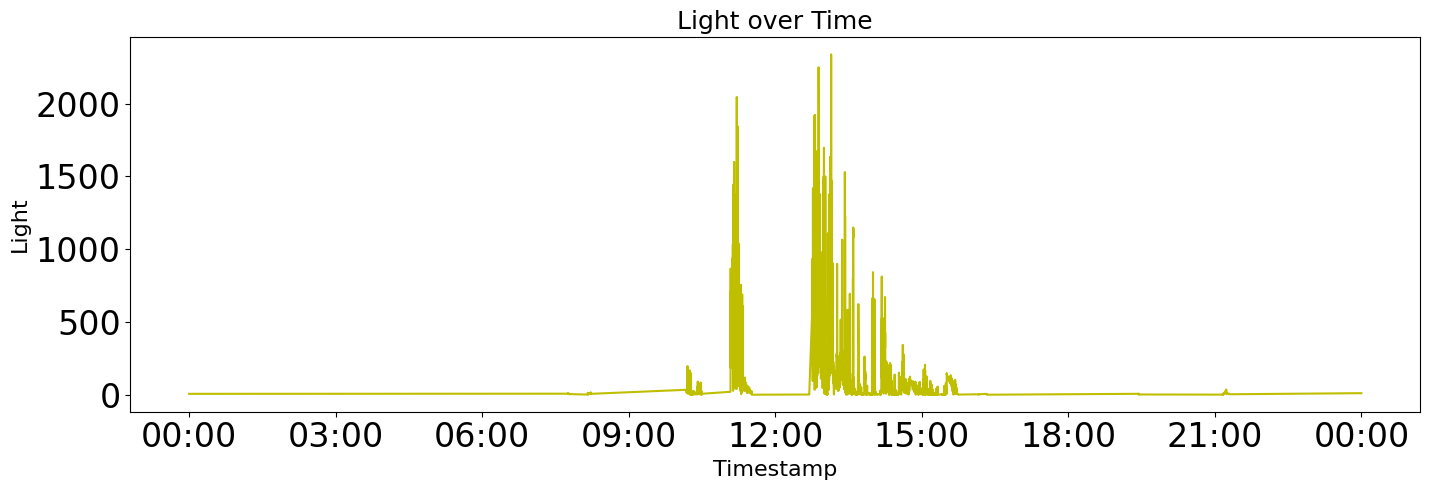

In [25]:
filtered_data_ = filtered_data[filtered_data['which_day']==3]

import matplotlib.dates as mdates

plt.figure(figsize=(14.4, 5))  # Adjust the figure size if needed
plt.plot(filtered_data_['timestamp'], filtered_data_['light'], linestyle='-', color='y')

# Adding labels and title with increased font size
plt.xlabel('Timestamp', fontsize=16)  # Increased font size for x-axis label
plt.ylabel('Light', fontsize=16)     # Increased font size for y-axis label
plt.title('Light over Time', fontsize=18)  # Increased font size for title

# Formatting the x-axis to display HH:MM format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0, fontsize=24)  # Increased font size for x-axis tick labels
plt.yticks(fontsize=24)              # Increased font size for y-axis tick labels

# Show the plot
plt.tight_layout()  # To ensure the layout is nice
plt.show()

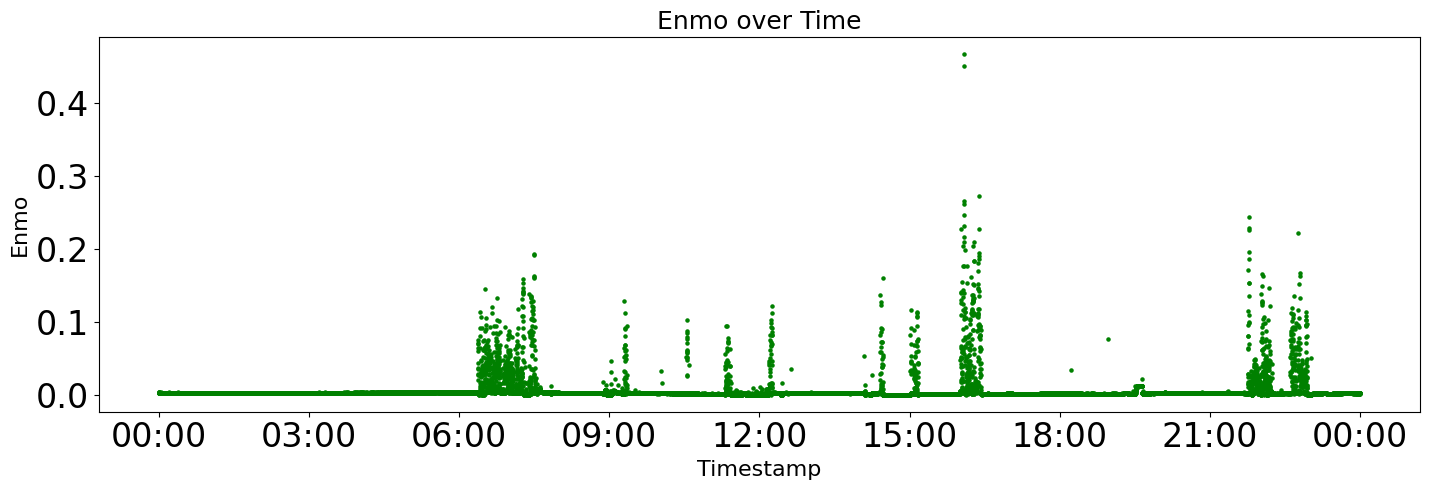

In [42]:
filtered_data_ = filtered_data[filtered_data['which_day']==12]

import matplotlib.dates as mdates

plt.figure(figsize=(14.4, 5))  # Adjust the figure size if needed
plt.scatter(filtered_data_['timestamp'], filtered_data_['enmo'], color='green', label='ENMO', s=5)  # 's' controls dot size


# Adding labels and title with increased font size
plt.xlabel('Timestamp', fontsize=16)  # Increased font size for x-axis label
plt.ylabel('Enmo', fontsize=16)     # Increased font size for y-axis label
plt.title('Enmo over Time', fontsize=18)  # Increased font size for title

# Formatting the x-axis to display HH:MM format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0, fontsize=24)  # Increased font size for x-axis tick labels
plt.yticks(fontsize=24)              # Increased font size for y-axis tick labels

# Show the plot
plt.tight_layout()  # To ensure the layout is nice
plt.show()

In [27]:
filtered_data.columns

Index(['timestamp_2', 'step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag',
       'light', 'battery_voltage', 'time_of_day', 'weekday', 'quarter',
       'relative_date_PCIAT', 'total_seconds', 'hour', 'minute', 'second',
       'time_of_day_hours', 'time_of_day_half_hours',
       'time_of_day_half_half_hours', 'time_of_day_fivemin_hours', 'day_time',
       'day_period', 'which_day', 'day_period_b', 'date', 'timestamp',
       'anglezdiffabs', 'anglezdiffabs_median_60', 'large_enmo',
       'anglezdiffabs_median_60_norm'],
      dtype='object')

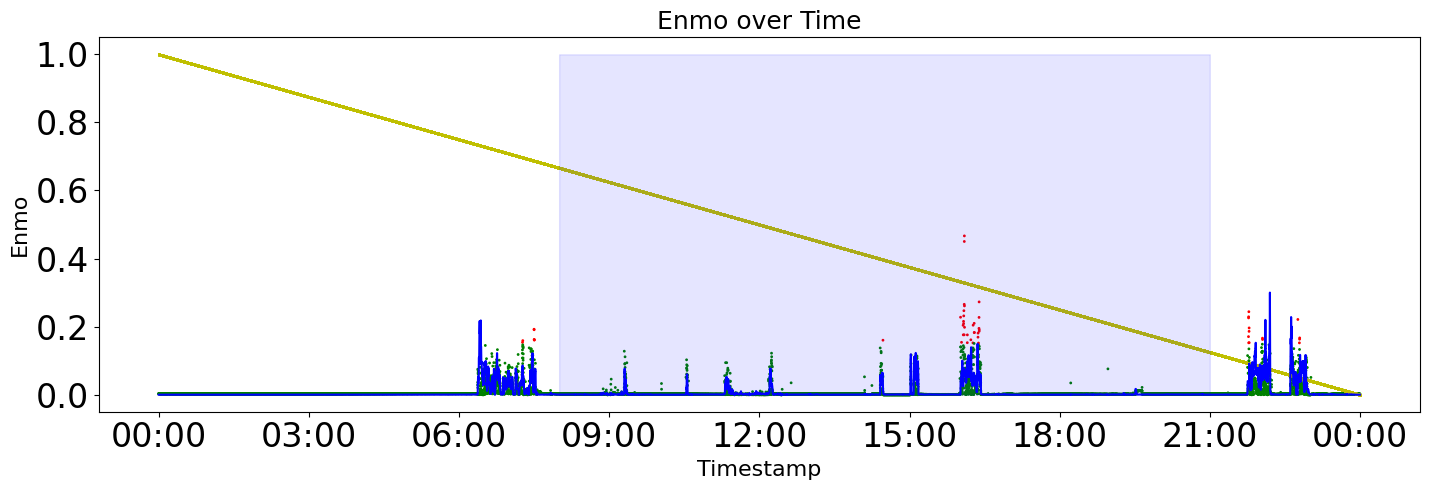

In [43]:
filtered_data_ = filtered_data[(filtered_data['which_day']==12)]
#filtered_data_ = filtered_data
filtered_data_['color'] = ["red" if large_enmo else "green" for large_enmo in filtered_data_['large_enmo']]
filtered_data_['enmo'] = np.clip(filtered_data_['enmo'], 0, 1)
filtered_data_['light'] = (filtered_data_['light'] - filtered_data_['light'].min()) / (filtered_data_['light'].max() - filtered_data_['light'].min())

import matplotlib.dates as mdates

plt.figure(figsize=(14.4, 5))  # Adjust the figure size if needed
plt.plot(filtered_data_['timestamp'], filtered_data_['anglezdiffabs_median_60_norm'], linestyle='-', color='b')
plt.scatter(filtered_data_['timestamp'], filtered_data_['enmo'],color=filtered_data_['color'], s=1)
plt.scatter(filtered_data_['timestamp'], filtered_data_['light'],color='y', s=1)
plt.fill_between(filtered_data_['timestamp'],
                                 0, max(1,filtered_data_['anglezdiffabs_median_60_norm'].max()), 
                                 where=(filtered_data_['day_period_b'] == 1), 
                                 color='blue', alpha=0.1, label='Day Period')

# Adding labels and title with increased font size
plt.xlabel('Timestamp', fontsize=16)  # Increased font size for x-axis label
plt.ylabel('Enmo', fontsize=16)     # Increased font size for y-axis label
plt.title('Enmo over Time', fontsize=18)  # Increased font size for title

# Formatting the x-axis to display HH:MM format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0, fontsize=24)  # Increased font size for x-axis tick labels
plt.yticks(fontsize=24)              # Increased font size for y-axis tick labels

# Show the plot
plt.tight_layout()  # To ensure the layout is nice
plt.show()

In [ ]:
filtered_data = feat_eng_by_id('abac67cc')
df[df['id']=='abac67cc']

In [ ]:
df.columns

In [ ]:
filtered_df = df[(df['id']=='35fa2ebf') | 
                 (df['id']=='01085eb3') | 
                 (df['id']=='00115b9f') | 
                 (df['id']=='045a0a94')][['id', 'sii', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-Height', 
                                           'Physical-Weight', 'Physical-Diastolic_BP', 'BIA-BIA_FMI', 
                                           'SDS-SDS_Total_T', 'FGC-FGC_CU']]

# Sort the filtered dataframe by the 'sii' column in ascending order
sorted_df = filtered_df.sort_values(by='sii', ascending=True)  # Use ascending=False for descending order
sorted_df

In [ ]:
filtered_data_ = filtered_data[filtered_data['which_day']==7]

import matplotlib.dates as mdates

plt.figure(figsize=(14.4, 5))  # Adjust the figure size if needed
plt.plot(filtered_data_['timestamp'], filtered_data_['anglez'], linestyle='-', color='b')

# Adding labels and title with increased font size
plt.xlabel('Timestamp', fontsize=16)  # Increased font size for x-axis label
plt.ylabel('Anglez', fontsize=16)     # Increased font size for y-axis label
plt.title('Anglez over Time', fontsize=18)  # Increased font size for title

# Formatting the x-axis to display HH:MM format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0, fontsize=24)  # Increased font size for x-axis tick labels
plt.yticks(fontsize=24)              # Increased font size for y-axis tick labels

# Show the plot
plt.tight_layout()  # To ensure the layout is nice
plt.show()

In [ ]:
filtered_data_.columns

In [ ]:
filtered_data_ = filtered_data[filtered_data['which_day']==7]
filtered_data_['anglez_normalized'] = (filtered_data_['anglez'] - filtered_data_['anglez'].min()) / (filtered_data_['anglez'].max() - filtered_data_['anglez'].min())

import matplotlib.dates as mdates

plt.figure(figsize=(14.4, 5))  # Adjust the figure size if needed

# Plot normalized anglez as a line
plt.plot(filtered_data_['timestamp'], filtered_data_['anglez_normalized'], linestyle='-', color='b', label='Normalized Anglez')

# Plot enmo as dots (scatter)
plt.scatter(filtered_data_['timestamp'], filtered_data_['enmo'], color='green', label='ENMO', s=5)  # 's' controls dot size

# Adding labels and title with increased font size
plt.xlabel('Timestamp', fontsize=16)  # Increased font size for x-axis label
plt.ylabel('Anglez Normalized', fontsize=16)     # Increased font size for y-axis label
plt.title('Normalized Anglez over Time', fontsize=18)  # Increased font size for title

# Formatting the x-axis to display HH:MM format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0, fontsize=24)  # Increased font size for x-axis tick labels
plt.yticks(fontsize=24)              # Increased font size for y-axis tick labels

# Show legend
plt.legend(fontsize=14)

# Show the plot
plt.tight_layout()  # To ensure the layout is nice
plt.show()

In [ ]:
# Get unique 'which_day' values
unique_days = filtered_data['which_day'].unique()

# Set up subplots (one plot for each unique 'which_day')
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14.4, 6 * len(unique_days)))

# If only one plot, `axes` is an array, so we handle this case
if len(unique_days) == 1:
    axes = [axes]

# Loop through each unique 'which_day' and plot on a separate subplot
for i, day in enumerate(unique_days):
    ax = axes[i]
    
    # Filter data for the current 'which_day'
    filtered_data_day = filtered_data[filtered_data['which_day'] == day]
    
    # Plot the 'anglez' values for this day
    ax.plot(filtered_data_day['timestamp'], filtered_data_day['anglez'], linestyle='-', color='b')

    # Adding labels and title with increased font size
    ax.set_xlabel('Timestamp', fontsize=16)
    ax.set_ylabel('Anglez', fontsize=16)
    ax.set_title(f'Anglez over Time for Day {day}', fontsize=18)

    # Formatting the x-axis to display HH:MM format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Rotate the x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
filtered_data = feat_eng_by_id('7f44236f') # df556fd2
df[df['id']=='7f44236f']

In [ ]:
# Get unique 'which_day' values
unique_days = filtered_data['which_day'].unique()

# Set up subplots (one plot for each unique 'which_day')
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14.4, 6 * len(unique_days)))

# If only one plot, `axes` is an array, so we handle this case
if len(unique_days) == 1:
    axes = [axes]

# Loop through each unique 'which_day' and plot on a separate subplot
for i, day in enumerate(unique_days):
    ax = axes[i]
    
    # Filter data for the current 'which_day'
    filtered_data_day = filtered_data[filtered_data['which_day'] == day]
    
    # Plot the 'anglez' values for this day
    ax.plot(filtered_data_day['timestamp'], filtered_data_day['anglez'], linestyle='-', color='b')

    # Adding labels and title with increased font size
    ax.set_xlabel('Timestamp', fontsize=16)
    ax.set_ylabel('Anglez', fontsize=16)
    ax.set_title(f'Anglez over Time for Day {day}', fontsize=18)

    # Formatting the x-axis to display HH:MM format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Rotate the x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import json
import gc
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np  # Ensure np is imported for handling int64 types

def process_and_plot(series_ids, images_folder):
    
    # Initialize main lists to hold all data
    window_properties = []
    all_events = []
    
    # Batch tracking lists
    batch_size = 50  # Adjust batch size to your memory constraints
    batch_window_properties = []
    batch_all_events = []
    
    # Files for saving batches of data
    window_properties_batch_file = images_folder / "window_properties.json"
    all_events_batch_file = images_folder / "all_events.json"

    # Create files if they don't exist
    window_properties_batch_file.touch(exist_ok=True)
    all_events_batch_file.touch(exist_ok=True)

    # Process the series_ids
    for idx in tqdm(series_ids):
        
        filtered_data = feat_eng_by_id(idx)

        series = filtered_data.reset_index(drop=True)
        series['color'] = ["blue" if large_enmo else "green" for large_enmo in series['large_enmo']]
        series['timestamp'] = pd.to_datetime(series['timestamp'])
        series['timestamp'] = series['timestamp'].apply(lambda x: x if x.tzinfo is not None else x.tz_localize('UTC'))
        series['timestamp_utc'] = series['timestamp'].map(lambda timestamp: timestamp.astimezone(timezone.utc))
        series['anglez_radians'] = (np.pi / 180) * series['anglez']
        series['cos_anglez'] = np.cos(series['anglez_radians'])
        series['enmo'] = np.clip(series['enmo'], 0, 1)
        min_date_utc = series['timestamp_utc'].dt.date.min()
        max_date_utc = series['timestamp_utc'].dt.date.max()
        
        series_24_hour_windows = {}
        upper_bound = datetime(year=min_date_utc.year, month=min_date_utc.month, day=min_date_utc.day, hour=20, minute=30, tzinfo=timezone.utc)
        lower_bound = upper_bound + timedelta(hours=-24) # 8:30pm UTC on the previous day.
        while lower_bound < series['timestamp_utc'].max():
            window_df = series.loc[(series['timestamp_utc'] >= lower_bound) & (series['timestamp_utc'] < upper_bound)].reset_index(drop=True)
            if len(window_df) > 0:
                series_24_hour_windows[upper_bound.isoformat()[:-6]] = window_df
            upper_bound += timedelta(hours=24)
            lower_bound += timedelta(hours=24)
        
        windows = list(series_24_hour_windows.keys())
        num_steps_cumulative = 0
        
        for window_idx, window in enumerate(windows):
            
             if (series_24_hour_windows[window]['non-wear_flag'].mean()<0.5) & (len(series_24_hour_windows[window]) == 17280): 

                day = series_24_hour_windows[window]['which_day'].iloc[0]
                 
                fig = plt.figure(figsize=(14.4, 4))  # (width, height) in inches
                #plt.plot(series_24_hour_windows[window]['timestamp_utc'], series_24_hour_windows[window]['cos_anglez'], color="red")
                plt.plot(series_24_hour_windows[window]['timestamp_utc'],
                             series_24_hour_windows[window]['anglezdiffabs_median_60_norm'],
                             color="red")
                plt.scatter(
                        series_24_hour_windows[window]['timestamp_utc'], 
                        series_24_hour_windows[window]['enmo'], 
                        color=series_24_hour_windows[window]['color'], 
                        s=1
                    )
                plt.scatter(series_24_hour_windows[window]['timestamp_utc'], series_24_hour_windows[window]['non-wear_flag'], label='non_wear_flag', color='red', alpha=0.7, s=10)
        
                plt.fill_between(series_24_hour_windows[window]['timestamp_utc'],
                                 0, max(1,series_24_hour_windows[window]['anglezdiffabs_median_60_norm'].max()), 
                                 where=(series_24_hour_windows[window]['non-wear_flag'] == 1), 
                                 color='red', alpha=0.1, label='Day Period')
                 
                plt.fill_between(series_24_hour_windows[window]['timestamp_utc'],
                                 0, max(1,series_24_hour_windows[window]['anglezdiffabs_median_60_norm'].max()), 
                                 where=(series_24_hour_windows[window]['day_period_b'] == 1), 
                                 color='blue', alpha=0.1, label='Day Period')
                ax = plt.gca()
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.margins(0, 0)
                plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        
                # Save image to images_folder
                image_path = images_folder / f"{idx}_{day}.jpg"
                plt.savefig(image_path, dpi=150, bbox_inches="tight", pad_inches=0)
                plt.close(fig)

                # Store data for batch, safely converting where necessary
                window_properties_item = {
                        'series_id': str(idx),  # Ensure series_id is stored as string
                        'image_name': f"{idx}_{day}.jpg", 
                        'idx_in_series': int(day)  # Convert 'day' to int if it's a number
                    }
                window_properties.append(window_properties_item)
                batch_window_properties.append(window_properties_item)  # Add to batch

                # Add to all_events batch
                sii_label = df.loc[df['id'] == idx, 'sii'].values.item()

                # Ensure sii_label is numeric before converting to int
                if isinstance(sii_label, (int, np.integer)):
                    sii_label = int(sii_label)
                else:
                    sii_label = str(sii_label)  # If it's a string, store it as string

                all_events_item = {'series_id': str(idx), 'image_name': f"{idx}_{day}.jpg", 'label': sii_label}
                all_events.append(all_events_item)
                batch_all_events.append(all_events_item)  # Add to batch

                # Save in batches when batch size is reached
                if len(batch_window_properties) >= batch_size:
                    # Save window_properties batch to JSON file
                    with open(window_properties_batch_file, "a") as f:
                        json.dump(batch_window_properties, f, indent=4)
                    batch_window_properties.clear()  # Clear the batch

                    # Save all_events batch to JSON file
                    with open(all_events_batch_file, "a") as f:
                        json.dump(batch_all_events, f, indent=4)
                    batch_all_events.clear()  # Clear the batch

                gc.collect()  # Clean up memory after each batch

    # After the loop, save any remaining data if the final batch wasn't full
    if batch_window_properties:
        with open(window_properties_batch_file, "a") as f:
            json.dump(batch_window_properties, f, indent=4)
    if batch_all_events:
        with open(all_events_batch_file, "a") as f:
            json.dump(batch_all_events, f, indent=4)



In [ ]:
process_and_plot(series_ids,images_folder)

In [ ]:
import glob

In [ ]:
def load_all_data_from_batches(directory_path, file_prefix):
    all_data = []
    
    # Get all filenames matching the prefix and pattern
    batch_files = glob.glob(f"{directory_path}/{file_prefix}*.json")
    
    for batch_file in batch_files:
        with open(batch_file, 'r') as f:
            try:
                data = json.load(f)
                all_data.extend(data)  # Append data from this batch to the overall list
            except json.JSONDecodeError as e:
                print(f"Error loading {batch_file}: {e}")
    
    return all_data
    

In [ ]:
# Path to your JSON files
window_properties_path = '/kaggle/working/imagesandannotations/window_properties.json'
all_events_path = '/kaggle/working/imagesandannotations/all_events.json'

# Function to load and fix the JSON files if needed
def load_json_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    # Remove any invalid '][' and ensure the content is wrapped in square brackets
    fixed_content = content.replace("][", ",")  # Fix '][' by replacing with a comma

    # Wrap content in square brackets if it's not already
    if not fixed_content.startswith('['):
        fixed_content = f"[{fixed_content}"
    if not fixed_content.endswith(']'):
        fixed_content = f"{fixed_content}]"

    # Try to load the corrected content
    try:
        data = json.loads(fixed_content)
        print(f"Successfully loaded {file_path}!")
        return data
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_path}: {e}")
        return None

# Load both files
window_properties_data = load_json_file(window_properties_path)
all_events_data = load_json_file(all_events_path)

# Print a sample from each to confirm the data is loaded correctly
print("Sample from window_properties:")
print(window_properties_data[:3])  # Show the first 3 items as a sample

print("\nSample from all_events:")
print(all_events_data[:3])  # Show the first 3 items as a sample

In [ ]:
window_properties_df = pd.DataFrame(window_properties_data)
window_properties_df.head(5)

In [ ]:
annotations_df = pd.DataFrame(all_events_data)
annotations_df.head(5)